## Metalearning Notes
*Calvin Tong 2018-09-17*

## Introduction
Metalearning for parameter instantiation might be a useful tool for model generalization. The idea is to learn parameters $\phi$ such that the model will have low loss given $k$ training iterations. More formally, given a task $\tau$ with loss function $L_\tau$ we 

$$
\begin{equation*}
\begin{aligned}
\underset{\phi}{\text{minimize}} && \mathbb{E} [L_\tau (U_\tau^k(\phi))]
\end{aligned}
\end{equation*}
$$

where $U_k^\tau$ is an operator defining k updates to $\phi$ using data sampled from $\tau$.

### Reptile in Action
Reptile is the successor to MAML and acheives similar preformance, but is easier to implement and faster at runtime. 

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# domain of the sin function
x_all = np.linspace(-5, 5, 50)

# Number of training iterations
n_iter = 30000

# Number of inner training iterations
n_iter_inner = 1

# Number of training iterations for evaluation
n_train = 10

# Alpha for inner and outer SGD
alpha_inner = 0.02
alpha_outer = 0.1

In [6]:
def build_model():
    """
    Build simple feedforward network in keras
    """
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='tanh', input_shape=(1,)))
    model.add(keras.layers.Dense(64, activation='tanh'))
    model.add(keras.layers.Dense(1))
    sgd = keras.optimizers.SGD(lr=alpha_inner)
    model.compile(optimizer=sgd,
                  loss='mse',
                  metrics=['accuracy'])
    return model

def gen_task():
    """
    Create regression problem
    """
    phase = np.random.uniform(0, 2*np.pi)
    ampl = np.random.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

In [7]:
model = build_model()

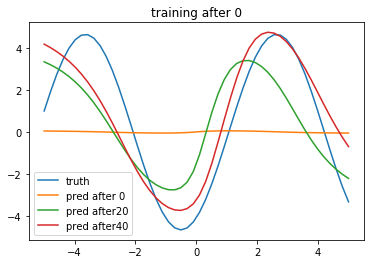

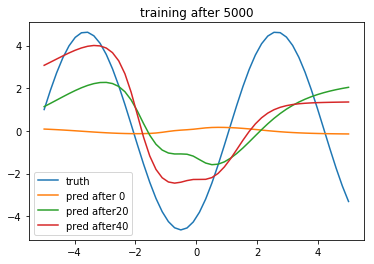

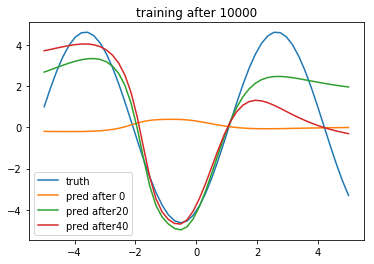

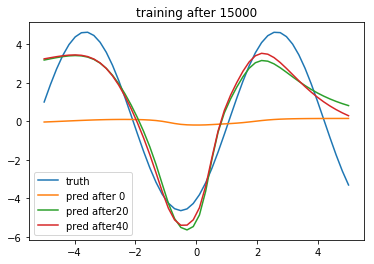

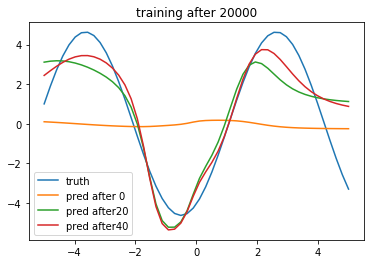

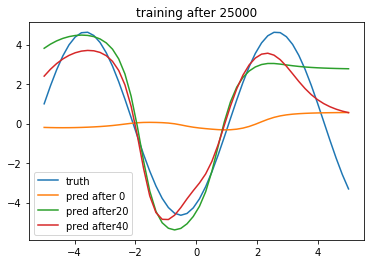

In [9]:
# Evaluation parameters
f_eval = gen_task()
eval_epoch = 20
num_plots = 2

for iteration in range(n_iter):
    # Save original weights
    weights_old = np.array(model.get_weights())
    
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    
    # Train on task with SGD
    inds = np.random.permutation(len(x_all))
    for s in range(0, len(x_all), n_train):   
        model.fit(x_all[s:s+n_train], y_all[s:s+n_train], epochs=n_iter_inner, verbose=0)
        
    # Update weights with pseudogradient
    weights_new = np.array(model.get_weights())
    outerstepsize = alpha_outer * (1 - iteration / n_iter)
    update = weights_old + (weights_new - weights_old) * outerstepsize
    model.set_weights(update.tolist())
    
    # Evaluate every 5000 epochs
    if iteration % 5000 == 0:
        # Save weights before
        weights_before = model.get_weights()
        
        # Plot initial predictions
        plt.figure()
        plt.plot(x_all, f_eval(x_all), label="truth")
        plt.plot(x_all, model.predict(x_all), label="pred after 0")
        
        # Train for eval_epoch and plot
        for i in range(num_plots):
            model.fit(x_all, f_eval(x_all), epochs=eval_epoch // num_plots, verbose=0)
            plt.plot(x_all, model.predict(x_all), label="pred after" + str(((i+1) * eval_epoch)))
        plt.legend()
        plt.title("training after " + str(iteration))     
        
        # Restore weights from before
        model.set_weights(weights_before)